In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rv_discrete


In [119]:
def sketching_matrix(d, m, method = 'gaussian'):
    """
        Construct oblivious sketches
    """
    if method == 'gaussian':
        S = np.random.randn(d, m)
    elif method == 'rademacher':
        S = 2*np.random.rand(d,m)-1
    elif method == 'uniform':
        S = np.random.uniform(-1,1, size=(d,m))
    return (S/np.sqrt(d)) 

### Sketch-and-solve

In [120]:
def sketch_and_solve(S, A, b):
    ### Sketched matrix and rhs
    SA = S @ A
    Sb = S @ b

    res = np.linalg.lstsq(SA, Sb, rcond = None)
    return res[0], res[1]

We consider a well-conditioned matrix with a small and large residual. See perturbation theory for least squares.

In [121]:
 m = 10**3; n = 20 
 A = np.random.randn(m, n)
 xt = np.ones((n,))
 print("Condition number of A", np.linalg.cond(A))
 
 # Small residual
 b = A @ xt + 1.e-6*np.random.randn(m)
 res = np.linalg.lstsq(A, b, rcond = None)
 xls = res[0]
 rls = res[1]

S = sketching_matrix(4*n, m, 'gaussian')
xs, rs = sketch_and_solve(S, A, b)
print("Small residual case.")
print("Relative error in computed solutions", np.linalg.norm(xs-xls)/np.linalg.norm(xls))
print("Residual norms are", np.linalg.norm(rls) , " and ",  np.linalg.norm(rs))

print("\n")

# Large residual
 b = A @ xt + 1.e-3*np.random.randn(m)
 res = np.linalg.lstsq(A, b, rcond = None)
 xls = res[0]
 rls = res[1]

S = sketching_matrix(4*n, m, 'uniform')
xs, rs= sketch_and_solve(S, A, b)
print("Large residual case.")
print("Relative error in computed solutions", np.linalg.norm(xs-xls)/np.linalg.norm(xls))
print("Residual norms are", np.linalg.norm(rls) , " and ",  np.linalg.norm(rs))



Condition number of A 1.302044352890523
Small residual case.
Relative error in computed solutions 1.2660582624995693e-07
Residual norms are 9.992877364427276e-10  and  7.785998477852096e-10


Large residual case.
Relative error in computed solutions 0.00014871300693121455
Residual norms are 0.000990295539374152  and  0.00023268981402124812


Now, let us consider a more ill-conditioned case

In [122]:

m = 10**3; n = 20 
A = np.random.randn(m, n)@ np.diag(0.7**np.arange(n))
xt = np.ones((n,))
print("Condition number of A", np.linalg.cond(A))
 
# Small residual
b = A @ xt + 1.e-6*np.random.randn(m)
res = np.linalg.lstsq(A, b, rcond = None)
xls = res[0]
rls = res[1]

S = sketching_matrix(4*n, m, 'gaussian')
xs, rs = sketch_and_solve(S, A, b)
print("Small residual case.")
print("Relative error in computed solutions", np.linalg.norm(xs-xls)/np.linalg.norm(xls))
print("Residual norms are", np.linalg.norm(rls) , " and ",  np.linalg.norm(rs))

print("\n")

# Large residual
b = A @ xt + 1.e-3*np.random.randn(m)
res = np.linalg.lstsq(A, b, rcond = None)
xls = res[0]
rls = res[1]

S = sketching_matrix(4*n, m, 'gaussian')
xs, rs= sketch_and_solve(S, A, b)
print("Large residual case.")
print("Relative error in computed solutions", np.linalg.norm(xs-xls)/np.linalg.norm(xls))
print("Residual norms are", np.linalg.norm(rls) , " and ",  np.linalg.norm(rs))


Condition number of A 876.9983470420676
Small residual case.
Relative error in computed solutions 2.969390374297675e-05
Residual norms are 9.58764671904784e-10  and  1.0215133174743217e-09


Large residual case.
Relative error in computed solutions 0.018238019654605645
Residual norms are 0.0009734849202032179  and  0.0006844643774046781


### Sketch-and-precondition

In [123]:
from scipy.sparse.linalg import LinearOperator, lsqr
def sketch_and_precondition(S, A, b, cond = True):
        SA = S @ A
        q, r = np.linalg.qr(SA, mode='reduced')

        Ap = LinearOperator(shape = A.shape, \
                            matvec = lambda x: A @ np.linalg.solve(r, x), \
                            rmatvec = lambda x: np.linalg.solve(r.T, A.T @ x), dtype = 'd')
        
        if cond:
                print("Prec cond number", np.linalg.cond(np.linalg.solve(r.T, A.T).T))

        res = lsqr(Ap,b)
        print('The number of preconditioned LSQR iterations is ',res[2])
        return np.linalg.solve(r, res[0])

Well-conditioned case

In [124]:
m = 10**3; n = 20 
A = np.random.randn(m, n)
xt = np.ones((n,))
print("Condition number of A", np.linalg.cond(A))
 
# Small residual
b = A @ xt + 1.e-6*np.random.randn(m)
res = np.linalg.lstsq(A, b, rcond = None)
xls = res[0]
rls = res[1]

print('Small residual case.')
S = sketching_matrix(4*n, m, 'gaussian')
xs= sketch_and_precondition(S, A, b)
print("Relative error is ", np.linalg.norm(xs-xls)/np.linalg.norm(xls))

res = lsqr(A,b)
print('The number of unpreconditioned LSQR iterations is ',res[2])

print("\n")

# Large residual
b = A @ xt + 1.e-3*np.random.randn(m)
res = np.linalg.lstsq(A, b, rcond = None)
xls = res[0]
rls = res[1]

print("Large residual case.")
xs= sketch_and_precondition(S, A, b)
print("Relative error in computed solutions", np.linalg.norm(xs-xls)/np.linalg.norm(xls))
res = lsqr(A,b)
print('The number of unpreconditioned LSQR iterations is ',res[2])


Condition number of A 1.276795898752397
Small residual case.
Prec cond number 2.9008783171336012
The number of preconditioned LSQR iterations is  21
Relative error is  1.4876574243286504e-15
The number of unpreconditioned LSQR iterations is  15


Large residual case.
Prec cond number 2.9008783171336012
The number of preconditioned LSQR iterations is  20
Relative error in computed solutions 1.104856639266863e-12
The number of unpreconditioned LSQR iterations is  12


Ill-conditioned case

In [125]:
m = 10**3; n = 20 
A = np.random.randn(m, n)@ np.diag(0.5**np.arange(n))
xt = np.ones((n,))
print("Condition number of A", np.linalg.cond(A))
 
# Small residual
b = A @ xt + 1.e-6*np.random.randn(m)
res = np.linalg.lstsq(A, b, rcond = None)
xls = res[0]
rls = res[1]

print('Small residual case.')
S = sketching_matrix(4*n, m, 'gaussian')
xs= sketch_and_precondition(S, A, b)
print("Relative error is ", np.linalg.norm(xs-xls)/np.linalg.norm(xls))

res = lsqr(A,b)
print('The number of unpreconditioned LSQR iterations is ',res[2])


print("\n")

# Large residual
b = A @ xt + 1.e-3*np.random.randn(m)
res = np.linalg.lstsq(A, b, rcond = None)
xls = res[0]
rls = res[1]

print("Large residual case.")
xs= sketch_and_precondition(S, A, b)
print("Relative error in computed solutions", np.linalg.norm(xs-xls)/np.linalg.norm(xls))
res = lsqr(A,b)
print('The number of unpreconditioned LSQR iterations is ',res[2])

Condition number of A 521521.5204568721
Small residual case.
Prec cond number 2.713826061334507
The number of preconditioned LSQR iterations is  21
Relative error is  8.360127386202404e-11
The number of unpreconditioned LSQR iterations is  40


Large residual case.
Prec cond number 2.713826061334507
The number of preconditioned LSQR iterations is  19
Relative error in computed solutions 1.26544328594752e-07
The number of unpreconditioned LSQR iterations is  40


### Large-sparse case

(1033, 320) (1033, 1)
Condition number of A 166.133339755426
The number of unpreconditioned LSQR iterations is  179
The number of preconditioned LSQR iterations is  62


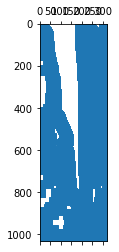

In [130]:
from scipy.io import loadmat
mat = loadmat('mat/well1033.mat')
A = mat['Problem'][0][0]['A']
b = mat['Problem'][0][0]['b']
print(A.shape, b.shape)
plt.spy(A)
print('Condition number of A', np.linalg.cond(A.todense()))

res = lsqr(A,b)
print('The number of unpreconditioned LSQR iterations is ',res[2])

S = sketching_matrix(2*A.shape[1], A.shape[0], 'gaussian')
xs= sketch_and_precondition(S, A, b, cond = False)

(1850, 712) (1850, 1)
Condition number of A 1404.9046829260417
The number of unpreconditioned LSQR iterations is  1424
The number of preconditioned LSQR iterations is  183


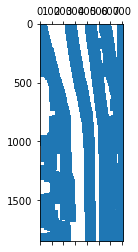

In [133]:
from scipy.io import loadmat
mat = loadmat('mat/illc1850.mat')
A = mat['Problem'][0][0]['A']
b = mat['Problem'][0][0]['b']
print(A.shape, b.shape)
plt.spy(A)
print('Condition number of A', np.linalg.cond(A.todense()))
res = lsqr(A,b)
print('The number of unpreconditioned LSQR iterations is ',res[2])

S = sketching_matrix(int(1.2*A.shape[1]), A.shape[0], 'gaussian')
xs= sketch_and_precondition(S, A, b, cond = False)